In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm
import BiQ_Common_Fxns as BiQ
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

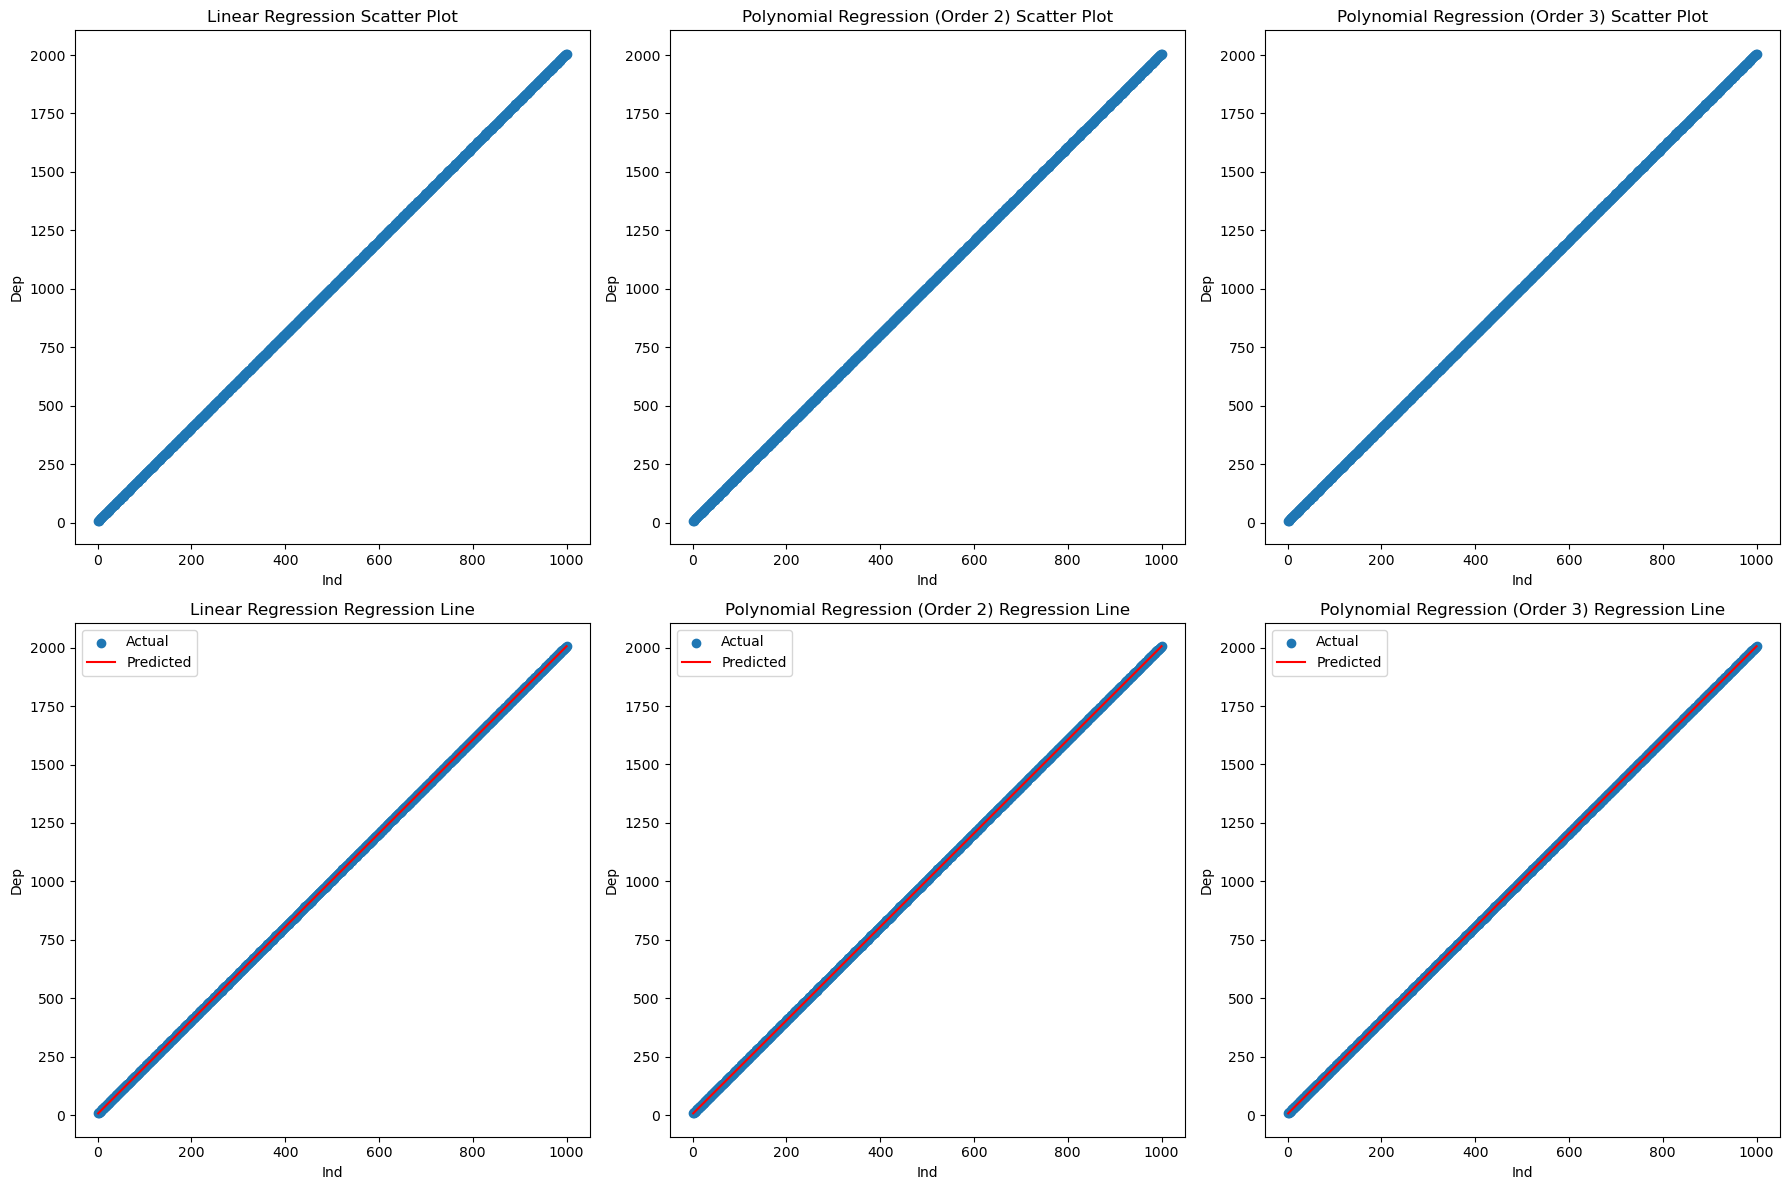

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tkinter import Tk, filedialog
from tabulate import tabulate
import statsmodels.api as sm

def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        return df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def get_user_column_selection(df, title):
    """Gets user input for selecting a column using dialog boxes."""
    # Get column names from the DataFrame
    columns = df.columns.tolist()

    while True:
        col_name = input(f"Enter the column name for {title}:\nAvailable columns: {', '.join(columns)}\n")
        if col_name in columns:
            return col_name
        else:
            print(f"Column '{col_name}' not found in the DataFrame.")

def fit_linear_regression(df, x_col, y_col):
    """Fit a linear regression model."""
    X = df[[x_col]]
    y = df[y_col]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return model, y_pred

def fit_polynomial_regression(df, x_col, y_col, degree):
    """Fit a polynomial regression model."""
    X = df[[x_col]]
    y = df[y_col]

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)
    return model, polynomial_features


def calculate_regression_stats(model, X, y):
    """Calculate regression statistics."""
    y_pred = model.predict(X)
    residuals = y - y_pred
    n = len(y)
    p = X.shape[1] - 1  # Number of predictors excluding the intercept

    multiple_r = np.sqrt(model.score(X, y))
    r_squared = model.score(X, y)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))
    std_err = np.sqrt(np.sum(residuals**2) / (n - p - 1))

    return multiple_r, r_squared, adj_r_squared, std_err, n

def plot_scatter(ax, df, x_col, y_col, title):
    """Plot a scatter plot."""
    ax.scatter(df[x_col], df[y_col])
    ax.set_title(f'{title} Scatter Plot')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

def plot_regression_line(ax, df, x_col, y_pred, y_col, title):
    """Plot a regression line."""
    ax.scatter(df[x_col], df[y_col], label='Actual')
    ax.plot(df[x_col], y_pred, color='red', label='Predicted')
    ax.set_title(f'{title} Regression Line')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()

def main():
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    if not file_path:
        print("No file selected.")
        return

    # Read Excel file into DataFrame
    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    x_col = get_user_column_selection(df, "Independent Variable (X)")
    if x_col is None:
        print("Error: Invalid input for independent variable.")
        return

    y_col = get_user_column_selection(df, "Dependent Variable (Y)")
    if y_col is None:
        print("Error: Invalid input for dependent variable.")
        return

    # Fit linear regression
    linear_model, linear_y_pred = fit_linear_regression(df, x_col, y_col)

    # Handle polynomial regression
    degree_poly2 = 2  # Degree for polynomial regression order 2
    degree_poly3 = 3  # Degree for polynomial regression order 3

    poly2_model, poly2_features, poly2_y_pred = fit_polynomial_regression(df, x_col, y_col, degree=degree_poly2)
    poly3_model, poly3_features, poly3_y_pred = fit_polynomial_regression(df, x_col, y_col, degree=degree_poly3)

    # Now you can use linear_model and linear_y_pred in the models dictionary
    models = {
        'Linear Regression': (linear_model, linear_y_pred),
        'Polynomial Regression (Order 2)': (poly2_model, poly2_y_pred),
        'Polynomial Regression (Order 3)': (poly3_model, poly3_y_pred),
    }
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    for i, (model_name, (model, y_pred)) in enumerate(models.items()):
        if i < 3:
            plot_scatter(axs[0, i], df, x_col, y_col, model_name)
            plot_regression_line(axs[1, i], df, x_col, y_pred, y_col, model_name)

    plt.tight_layout()
    plt.show()

    coef_data = []

    for model_name, (model, features) in models.items():
        coef_results = []  # Initialize coef_results for each model
        X = df[[x_col]] if features is None else features.transform(df[[x_col]])
        y = df[y_col]
        model = calculate_regression_stats(model, X, y)
        coef_names = model.params.index.tolist()  # Get coefficient names

        for coef_name, coef_value, std_err, t_value, p_value in zip(
            model.params.index, model.params.values, model.bse.values, model.tvalues.values,
            model.pvalues.values
        ):
            coef_results.append([coef_name, coef_value.round(3), std_err.round(3),
                                 t_value.round(3), p_value.round(3)])

        coef_data.append([model_name] + coef_results)

    # Print Coefficients Table
    for model_coef_data in coef_data:
        print(f"\n{model_coef_data[0]} Coefficients:")
        print(tabulate(model_coef_data[1:], headers=["Coefficient", "Estimate", "Std. Error",
                                                     "t value", "P>|t|"],
                       tablefmt="grid"))

if __name__ == "__main__":
    main()